In [1]:
# Install MySql packages
# conda update -n base -c conda-forge conda --yes
# !pip install ipython-sql
# !pip install mysql-connector-python
# !conda install -c conda-forge python-dotenv --yes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import mysql.connector
from mysql.connector import Error
from os import environ, path
from dotenv import load_dotenv

In [3]:
# Read enviromental variables to connect the database
load_dotenv()
password = environ.get('PASSWORD')
host = environ.get('HOST')
database = environ.get('DATABASE')

## Connect to the database and create dataframes for each table

In [4]:
try:
    connection = mysql.connector.connect(host=host ,
                                        database=database,
                                        user='root',
                                        password=password)
    if connection.is_connected():
        print("Succes Connected")
    df_musician = pd.read_sql_query("SELECT * FROM music_and_death.musician;", connection)
    df_birth = pd.read_sql_query("SELECT * FROM music_and_death.birth;", connection)
    df_death = pd.read_sql_query("SELECT * FROM music_and_death.death;", connection)
    df_genre = pd.read_sql_query("SELECT * FROM music_and_death.music_genre;", connection)
    genre = pd.read_sql_query("SELECT * FROM music_and_death.genre;", connection)
    cause_death = pd.read_sql_query("SELECT * FROM music_and_death.cause_death;", connection)
    cities = pd.read_sql_query("SELECT * FROM music_and_death.cities;", connection)
    states = pd.read_sql_query("SELECT * FROM music_and_death.states;", connection)
    countries = pd.read_sql_query("SELECT * FROM music_and_death.countries;", connection)
    
    
except Error as e:
    print("Error closing connection")

# Concatenate tables
else:
    # Concatenate musician and death dataframes
    df = pd.concat([df_musician, df_birth], axis=1)
    df = pd.concat([df, df_death], axis=1)
    df = pd.merge(df, cause_death, on=["death_id", "death_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, df_genre, on=["musician_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, genre, on=["genre_id"])
    # rearrange columns
    df = df.iloc[:, [0, 1, 2, 3, 5, 7, 8, 9, 11, 6, 4, 10]]
    
finally:
    connection.close()

Succes Connected


/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordat

## Merge and clean the cities, states and countries tables

In [5]:
# merge cities table with states table
place = cities.merge(states, 
                      left_on=cities["state_id"], 
                      right_on=states["id"])

# drop duplicate keys
place.drop(['key_0', 'state_id', 'id_y'], axis=1, inplace=True)

# merge resulted table with countries table
place = place.merge(countries, 
                        left_on=place["country_id"],
                        right_on=countries["id"])

# drop duplicated keys
place.drop(['key_0', 'country_id', 'id', 'iso2', 'capital'], 
              axis=1, 
              inplace=True)

# rename column names
place.rename(
    columns={'name_x': 'City', 
             'name_y': 'State', 
             'name': 'Country', 
             'id_x': 'city_id'},
    inplace=True
)

##  Drop columns with not use

In [6]:
df.drop(['middle_name', 'death_id', "death_date", "genre_id", "birth"], 
        axis=1, 
        inplace=True)

In [7]:
df

,musician_id,stage_name,stage_lastname,death_age,cause,genre,birthplace_id
0,1,John,Lennon,40,homicide,rock,50337
1,2,Kurt,Cobain,27,suicide,rock,110979
2,17,Chris,Cornell,52,suicide,rock,126104
3,18,Chester,Bennington,41,suicide,rock,124148
4,32,Ian,Curtis,23,suicide,rock,51499
...,...,...,...,...,...,...,...
211,37,Johnny,Cash,71,diabetes,country,114248
212,148,A.,Carter,68,unknown,country,126050
213,175,Richard,Fariña,29,car accident,folk,122795
214,190,Woody,Guthrie,55,brain disorder,folk,123401


In [8]:
place

,city_id,City,State,Country
0,52,Ashkāsham,Badakhshan,Afghanistan
1,68,Fayzabad,Badakhshan,Afghanistan
2,78,Jurm,Badakhshan,Afghanistan
3,84,Khandūd,Badakhshan,Afghanistan
4,115,Rāghistān,Badakhshan,Afghanistan
...,...,...,...,...
148261,131496,Redcliff,Midlands Province,Zimbabwe
148262,131502,Shangani,Midlands Province,Zimbabwe
148263,131503,Shurugwi,Midlands Province,Zimbabwe
148264,131504,Shurugwi District,Midlands Province,Zimbabwe


## Merge musician info dataframe with place dataframe

In [9]:
# merge df and place dataframes
musician = df.merge(place, 
                    left_on=df['birthplace_id'], 
                    right_on=place['city_id'])

# drop unused columns
musician.drop(['birthplace_id', 'city_id', 'key_0'], axis=1, inplace=True)

In [10]:
musician

,musician_id,stage_name,stage_lastname,death_age,cause,genre,City,State,Country
0,1,John,Lennon,40,homicide,rock,Liverpool,England,United Kingdom
1,188,Brian,Epstein,32,drug overdose,rock,Liverpool,England,United Kingdom
2,2,Kurt,Cobain,27,suicide,rock,Aberdeen,Washington,United States
3,17,Chris,Cornell,52,suicide,rock,Seattle,Washington,United States
4,8,Jimi,Hendrix,27,alcohol overdose,rock,Seattle,Washington,United States
...,...,...,...,...,...,...,...,...,...
210,207,Red,Foley,58,heart disease,country,Lincoln County,Kentucky,United States
211,37,Johnny,Cash,71,diabetes,country,Cleveland County,Arkansas,United States
212,148,A.,Carter,68,unknown,country,Scott County,Virginia,United States
213,190,Woody,Guthrie,55,brain disorder,folk,Okemah,Oklahoma,United States


## Create plots to observe the data

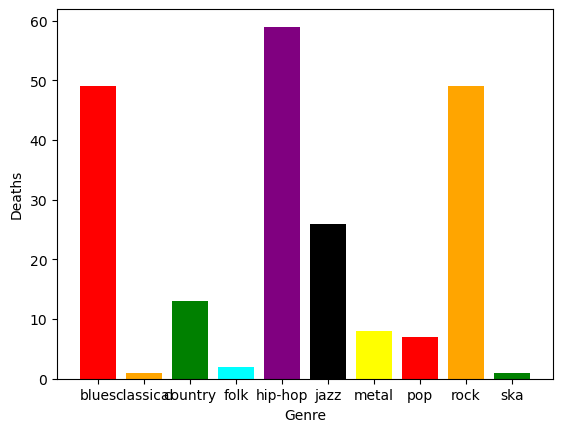

In [11]:
# Bar plot to show deaths per music genre 

# Create a new music table using genre as indez and size of each genre
df_n = musician.pivot_table(index=['genre'], aggfunc='size')

# plot the data
plt.bar(df_n.index, df_n, color=
        ['red', 'orange', 'green', 'cyan', 'purple', 'black', 'yellow'])
plt.ylabel("Deaths")
plt.xlabel("Genre")
plt.show()

## Cause of death per music genre

In [12]:
df_cd = musician.pivot_table(index=['cause', 'genre'], aggfunc='size')
df_cd

cause                              genre  
AIDS                               pop        1
                                   rock       1
Falling                            rock       1
accidental self-inflicted gunshot  blues      1
aircraft accident                  blues      3
                                             ..
suicide                            ska        1
surgery                            blues      1
unknown                            blues      5
                                   country    1
                                   jazz       5
Length: 64, dtype: int64

# Questions

## Most common Death Ages


In [20]:
n_da = musician['death_age'].value_counts().nlargest(20)

In [21]:
n_da

27    13
28    10
37     9
25     8
30     8
32     8
34     8
21     8
33     7
45     6
26     5
38     5
36     5
53     5
20     5
44     4
19     4
29     4
58     4
43     4
Name: death_age, dtype: int64

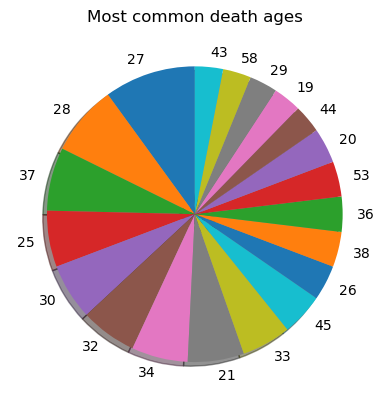

In [23]:

plt.pie(n_da.values, labels=n_da.index, startangle=90, shadow=True)
plt.title("Most common death ages")
# plt.legend(title='Death age', loc=(1, 0.25))
plt.show()

In [16]:
n_da.values

array([13, 10,  9,  8,  8,  8,  8,  8,  7,  6])

## Most common Music Genre

In [17]:
n_mg = musician['genre'].value_counts()

In [18]:
n_mg

hip-hop      59
rock         49
blues        49
jazz         26
country      13
metal         8
pop           7
folk          2
ska           1
classical     1
Name: genre, dtype: int64

<BarContainer object of 10 artists>

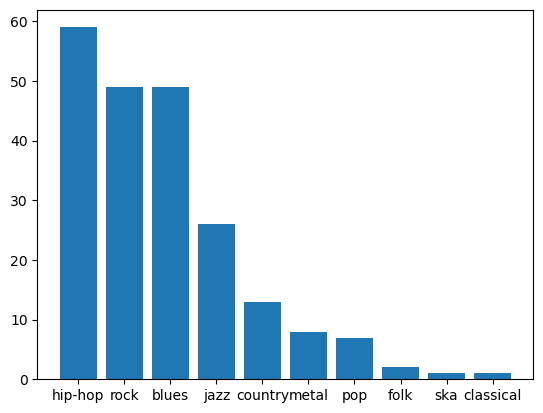

In [19]:
plt.bar(n_mg.index, n_mg.values)

# Places

### Most common Countries

In [25]:
n_places = musician['Country'].value_counts()

In [26]:
n_places

United States     174
United Kingdom     22
Australia           2
Germany             2
South Africa        1
Lithuania           1
India               1
Sweden              1
Netherlands         1
Canada              1
Brazil              1
Greece              1
Mexico              1
Haiti               1
Norway              1
New Zealand         1
Turkey              1
Tanzania            1
Jamaica             1
Name: Country, dtype: int64

### Most common States

In [31]:
n_states = musician['State'].value_counts().nlargest(20)

In [32]:
n_states

New York        24
England         18
California      18
Texas           16
Mississippi     15
Louisiana       12
Alabama         11
Georgia          9
Tennessee        7
Pennsylvania     7
Arkansas         5
Washington       5
Illinois         5
Florida          4
Scotland         4
Missouri         3
Indiana          3
Ohio             3
Minnesota        3
Virginia         3
Name: State, dtype: int64

### Most common Cities

In [33]:
n_cities = musician['City'].value_counts().nlargest(20)

In [34]:
n_cities

New York City         15
Los Angeles            8
New Orleans            6
Memphis                5
Philadelphia           5
London                 5
Chicago                4
Birmingham             4
Queens                 4
Atlanta                3
Dallas                 3
Baton Rouge            2
Montgomery             2
Greenwood              2
Detroit                2
Como                   2
Oakland                2
Houston                2
Liverpool              2
Saint Louis County     2
Name: City, dtype: int64

## Most common Cause o deaths

In [35]:
n_cause_death = musician['cause'].value_counts()

In [36]:
n_cause_death

homicide                             66
heart disease                        28
drug overdose                        18
cancer                               14
car accident                         14
aircraft accident                    13
suicide                              11
unknown                              11
brain disorder                        9
pneumonia                             8
alcohol overdose                      6
drawning                              6
diabetes                              4
AIDS                                  2
accidental self-inflicted gunshot     1
electrocution                         1
Falling                               1
natural                               1
surgery                               1
Name: cause, dtype: int64

# Correlation

### Genre - Cause of death

### Age - Cause of death

### Genre - Age